In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
import torch.optim as optim
import time
from torchvision import transforms, datasets
from PIL import Image
from torch.utils.data import DataLoader, random_split
from medmnist import OCTMNIST
import warnings
warnings.filterwarnings("ignore")

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # Resize to 28x28 if necessary
    transforms.Resize(size=(28, 28), antialias=True),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 32

# Define the dataset
dataset = OCTMNIST(root='../medmnist', split='train', download=True, transform=transform)

# Calculate sizes for each split
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

Using downloaded and verified file: ../medmnist/octmnist.npz


In [3]:
# Dataloaders
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [7]:
classes = list(dataset.info['label'].values())
classes

['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import os

# Create the saved_images folder if it doesn't exist
save_dir = 'saved_images'
os.makedirs(save_dir, exist_ok=True)
classes = list(dataset.info['label'].values())


# Function to display and save images
def imshow_and_save(img, filename):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.savefig(os.path.join(save_dir, filename))
    plt.show()

# Get 10 random images from testloader
test_dataiter = iter(testloader)
for i in range(10):
    images, labels = next(test_dataiter)
    for j in range(len(images)):
        image_name = f"{classes[labels[j]]}_{i * len(images) + j}.png" # Using class name as part of filename
        imshow_and_save(torchvision.utils.make_grid(images[j]), image_name)


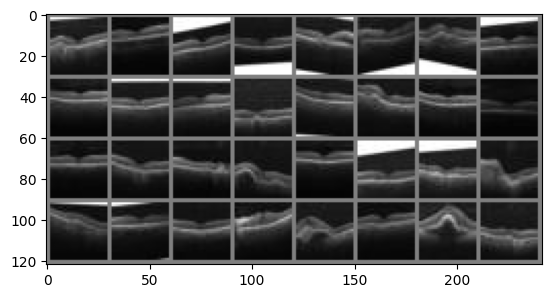

choroidal neovascularization normal normal normal choroidal neovascularization diabetic macular edema choroidal neovascularization normal normal drusen normal choroidal neovascularization normal choroidal neovascularization normal normal normal choroidal neovascularization choroidal neovascularization choroidal neovascularization normal drusen choroidal neovascularization choroidal neovascularization choroidal neovascularization normal normal diabetic macular edema choroidal neovascularization choroidal neovascularization choroidal neovascularization choroidal neovascularization


In [4]:
classes = list(dataset.info['label'].values())

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)
        self.dropout = nn.Dropout(p=0.2)  # Dropout layer with p=0.2

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        # Applying dropout after the first fully connected layer
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        # Applying dropout after the second fully connected layer
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [6]:
modelCNN = CNN()
print(modelCNN)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [7]:
# Define regularization (L2)
l2_reg = 0.001 # Regularization parameter
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelCNN.parameters(), lr=0.001, weight_decay=l2_reg)


In [8]:
import time

startTime = time.time()

training_loss_plt_arr = []
validation_loss_plt_arr = []
testing_loss_plt_arr = []

epochs = 5
consecutive_increases = 3
increase_count = 0
best_validation_loss = float('inf')

for epoch in range(epochs):
    training_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = modelCNN(inputs)
        labels = labels.flatten()
        loss_training = criterion(outputs, labels)
        loss_training.backward()
        optimizer.step()

        training_loss += loss_training.item()

        if i % 500 == 499:
            validation_loss = 0.0
            with torch.no_grad():
                for data in valloader:
                    images, labels = data
                    outputs = modelCNN(images)
                    labels = labels.flatten()
                    loss_validation = criterion(outputs, labels)
                    validation_loss += loss_validation.item()

            testing_loss = 0.0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    outputs = modelCNN(images)
                    labels = labels.flatten()
                    loss_testing = criterion(outputs, labels)
                    testing_loss += loss_testing.item()

            training_loss = round((training_loss / 500), 3)
            validation_loss = round((validation_loss / len(valloader)), 3)
            testing_loss = round((testing_loss / len(testloader)), 3)

            print(f"[{epoch + 1}, {i + 1}], Training loss: {training_loss}, Validation loss: {validation_loss}, Testing loss: {testing_loss}")

            training_loss_plt_arr.append(training_loss)
            validation_loss_plt_arr.append(validation_loss)
            testing_loss_plt_arr.append(testing_loss)
            training_loss = 0.0

            # Early stopping condition
            if validation_loss <= best_validation_loss:
                best_validation_loss = validation_loss
                increase_count = 0
            else:
                increase_count += 1
                if increase_count == consecutive_increases:
                    print("Stopping training as Validation Loss stopped improving.")
                    break

    if increase_count == consecutive_increases:
        break

print("Finished Training")

endTime = time.time()
time_to_train = (endTime - startTime)

# Convert total time to minutes and seconds
minutes = int(time_to_train // 60)
seconds = int(time_to_train % 60)

print(f"\nTime to train: {minutes}min {seconds}sec")

[1, 500], Training loss: 0.888, Validation loss: 0.69, Testing loss: 0.678
[1, 1000], Training loss: 0.669, Validation loss: 0.633, Testing loss: 0.627
[1, 1500], Training loss: 0.59, Validation loss: 0.57, Testing loss: 0.561
[1, 2000], Training loss: 0.56, Validation loss: 0.561, Testing loss: 0.553
[2, 500], Training loss: 0.508, Validation loss: 0.504, Testing loss: 0.493
[2, 1000], Training loss: 0.514, Validation loss: 0.541, Testing loss: 0.527
[2, 1500], Training loss: 0.496, Validation loss: 0.492, Testing loss: 0.479
[2, 2000], Training loss: 0.487, Validation loss: 0.5, Testing loss: 0.485
[3, 500], Training loss: 0.464, Validation loss: 0.455, Testing loss: 0.433
[3, 1000], Training loss: 0.46, Validation loss: 0.456, Testing loss: 0.437
[3, 1500], Training loss: 0.452, Validation loss: 0.494, Testing loss: 0.49
[3, 2000], Training loss: 0.437, Validation loss: 0.481, Testing loss: 0.465
Stopping training as Validation Loss stopped improving.
Finished Training

Time to trai

In [9]:
# Save model with weights
torch.save(modelCNN.state_dict(), 'ngupta22_assignment0_bonus.pt')

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)
        self.dropout = nn.Dropout(p=0.2)  # Dropout layer with p=0.2

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        # Applying dropout after the first fully connected layer
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        # Applying dropout after the second fully connected layer
        x = self.dropout(x)
        x = self.fc3(x)
        return x


# Load the trained model
modelCNN = CNN()
modelCNN.load_state_dict(torch.load('ngupta22_assignment0_bonus.pt'))
modelCNN.eval()


CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [46]:
# img = Image.open('./oct_img_data/cnv_eye.png').convert('L')
# img = Image.open('./oct_img_data/dme_eye.png').convert('L')
# img = Image.open('./oct_img_data/drusen_eye.png').convert('L')
# img = Image.open('./oct_img_data/normal_eye.png').convert('L')
img = Image.open('./testloaderImages/image_385_2.png').convert('L')

transform = transforms.Compose([
    transforms.ToTensor(),
    # Resize to 28x28 if necessary
    transforms.Resize(size=(28, 28), antialias=True),
    transforms.Normalize((0.5,), (0.5,))
])

# Preprocess the image
img = transform(img).unsqueeze(0)
with torch.no_grad():
    outputs = modelCNN(img)
    predicted = outputs.data
    print(predicted)

tensor([[ 0.2845, -2.7035,  1.2712, -0.1594]])


In [47]:
# img = Image.open('./oct_img_data/cnv_eye.png').convert('L')
# img = Image.open('./oct_img_data/dme_eye.png').convert('L')
# img = Image.open('./oct_img_data/drusen_eye.png').convert('L')
# img = Image.open('./oct_img_data/normal_eye.png').convert('L')
img = Image.open('./testloaderImages/image_385_2.png').convert('L')

transform = transforms.Compose([
    transforms.ToTensor(),
    # Resize to 28x28 if necessary
    transforms.Resize(size=(28, 28), antialias=True),
    transforms.Normalize((0.5,), (0.5,))
])

# Preprocess the image
img = transform(img).unsqueeze(0)
with torch.no_grad():
    outputs = modelCNN(img)
    predicted = outputs.data
    print(predicted)

tensor([[ 0.2845, -2.7035,  1.2712, -0.1594]])


In [27]:
def loadersAccuracy(loader):
    modelCNN.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = modelCNN(images)
            _, predicted = torch.max(outputs.data, 1)
            labels = labels.flatten()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = (correct / total * 100)
    return round(accuracy,2)

In [28]:
loadersAccuracy(testloader)

84.29

In [32]:
import os
from torchvision import datasets, transforms

# Create the testloaderImages folder if it doesn't exist
save_dir = 'testloaderImages'
os.makedirs(save_dir, exist_ok=True)

# Define image preprocessing
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert tensor to PILImage
])

# Iterate through the testloader and save images
counter = 0
for images, labels in testloader:
    for i in range(len(images)):
        image_name = f"image_{counter}_{labels[i].item()}.png"
        image_path = os.path.join(save_dir, image_name)
        image_pil = transform(images[i])  # Convert tensor to PILImage
        image_pil.save(image_path)
        counter += 1

In [31]:

modelCNN.eval()
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = modelCNN(images)
        print(outputs.data)
        print(labels.flatten())
        # _, predicted = torch.max(outputs.data, 1)
        # labels = labels.flatten()
        # total += labels.size(0)
        # correct += (predicted == labels).sum().item()


tensor([[ 3.0353, -3.6122,  1.2565, -2.1247],
        [ 0.5803, -0.1937, -0.7674, -0.8043],
        [ 3.6577, -3.9800,  1.0305, -2.4275],
        [-1.7011, -1.0559,  0.0804,  1.3404],
        [ 0.2388, -1.8605,  0.8672, -0.1981],
        [ 1.8370, -1.1016, -0.8376, -1.1454],
        [ 5.9349, -4.6184,  0.0226, -4.0718],
        [ 0.5138,  1.6153, -2.1121, -1.4607],
        [-1.8289, -0.8847, -0.1046,  1.4325],
        [-2.1801, -1.8165,  0.1687,  2.0365],
        [-2.1604, -1.2113, -0.2174,  1.9948],
        [-4.1456, -1.7952, -0.4680,  3.6814],
        [ 5.0375, -3.9783,  0.2242, -3.6483],
        [ 6.8638, -1.9594, -3.7146, -4.6843],
        [ 0.8460,  0.0358, -1.1349, -0.9364],
        [ 4.0520, -2.3975, -0.8305, -2.7767],
        [-0.5874, -2.4205,  0.7903,  0.7349],
        [ 3.7258, -2.4037, -0.5504, -2.5612],
        [-3.2249, -1.4244, -0.4256,  2.9060],
        [-2.3708, -1.6121,  0.0605,  2.1518],
        [ 3.9316, -2.8353, -0.4430, -2.4888],
        [ 4.0927, -2.6587, -0.5875